# NGS. HW2
Илья Шешуков

## Часть 1. Анализ ридов Illumina
### 0. Разбораться с Bowtie2 / bwa mem


```shell
$ bwa index data/ref.fasta.gz
[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.55 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.05 sec
[bwa_index] Construct SA from BWT and Occ... 0.32 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/ref.fasta.gz
[main] Real time: 3.029 sec; CPU: 1.990 sec

$ bwa mem data/ref.fasta.gz data/frag.R1.fastq.gz data/frag.R2.fastq.gz > frag.sam
[...]

$ samtools flagstat frag.sam
3432529 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
165 + 0 supplementary
0 + 0 duplicates
3424657 + 0 mapped (99.77% : N/A)
3432364 + 0 paired in sequencing
1716182 + 0 read1
1716182 + 0 read2
3407384 + 0 properly paired (99.27% : N/A)
3416620 + 0 with itself and mate mapped
7872 + 0 singletons (0.23% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

$ bwa mem data/ref.fasta.gz data/jump.R1.fastq.gz data/jump.R2.fastq.gz > jump.sam
[...]

$ samtools flagstat jump.sam
4328969 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
13369 + 0 supplementary
0 + 0 duplicates
4279501 + 0 mapped (98.86% : N/A)
4315600 + 0 paired in sequencing
2157800 + 0 read1
2157800 + 0 read2
3764298 + 0 properly paired (87.23% : N/A)
4216854 + 0 with itself and mate mapped
49278 + 0 singletons (1.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

```
### 1. Покрытие генома

``` shell
$ samtools sort -o frag.sorted frag.sam
[bam_sort_core] merging from 1 files and 1 in-memory blocks...

$ samtools index frag.sorted
```

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import pysam
from tqdm import tqdm
from itertools import zip_longest, islice, product
from collections import Counter, defaultdict, deque
import gzip
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

Avg coverage 129.93298393959955
Genome covered 100.0%


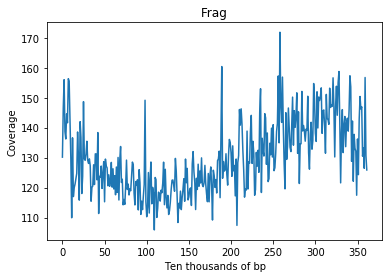

In [47]:
coverages = []
samfile = pysam.AlignmentFile("work/frag.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("Frag")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

Avg coverage 132.5870349332601
Genome covered 83.1343148572154%


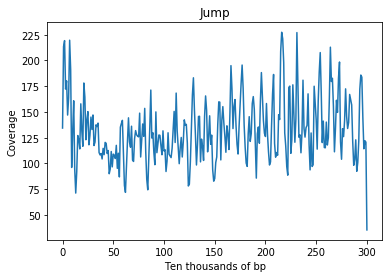

In [48]:
coverages = []
samfile = pysam.AlignmentFile("work/jump.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.n for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("Jump")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

### 2. Распределение расстояния вставки.

```
$ samtools stats jump.sorted | grep "^IS" | cut -f 3 > jump_insert
```

Mean: 267.7709252247219
Mse:  3743.399754822383
95 percentile interval: [178, 359]


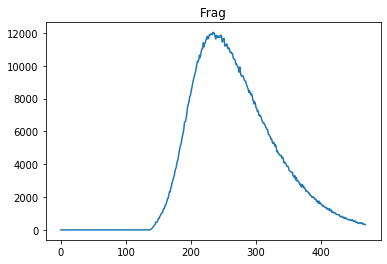

In [86]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

with open("work/frag_insert", "rb") as f:
    data = [int(line.rstrip()) for line in f.readlines()]

flatten = lambda l: [item for sublist in l for item in sublist]
hist = flatten([[n] * i for i, n in zip(data, range(len(data)))])

mean = np.mean(hist)
print(f'Mean: {mean}')
print(f'Mse:  {np.mean((hist - mean)**2)}')
m, a, b = mean_confidence_interval(data, confidence=0.95)
b, a = find_nearest(data, a), find_nearest(data, b)
print(f'95 percentile interval: [{a}, {b}]')

plt.plot(np.arange(len(data)), data)
plt.title('Frag')
plt.show()

Mean: 7254.61637878851
Mse:  1264697.3505283757
95 percentile interval: [150, 7947]


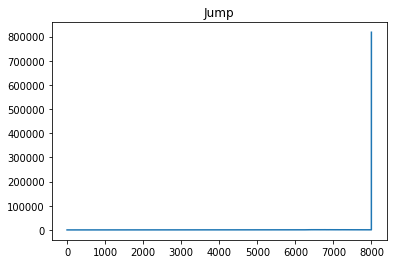

In [84]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

with open("work/jump_insert", "rb") as f:
    data = [int(line.rstrip()) for line in f.readlines()]

flatten = lambda l: [item for sublist in l for item in sublist]
hist = flatten([[n] * i for i, n in zip(data, range(len(data)))])

mean = np.mean(hist)
print(f'Mean: {mean}')
print(f'Mse:  {np.mean((hist - mean)**2)}')
m, a, b = mean_confidence_interval(data, confidence=0.95)
a, b = find_nearest(data, a), find_nearest(data, b)
print(f'95 percentile interval: [{a}, {b}]')

plt.plot(np.arange(len(data)), data)
plt.title('Jump')
plt.show()

### 3. Частоты различных замен

#### frag

In [68]:
mat = Counter()

with pysam.AlignmentFile('work/frag.sorted', 'rb') as file:
    for read in tqdm(file):
        try:
            aligned_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue

        for p in aligned_pairs:
            if (p[0] is None) or (p[2] is None) or (p[2] == 'N'):
                continue
                
            ref = p[2].upper()
            read_nucl = read.seq[p[0]].upper()
            
            if read_nucl == 'N':
                continue

            if read_nucl != ref:
                mat[(ref, read_nucl)] += 1

for n, i in enumerate('ACTG'):
    print(f" {i:>{8}}", end="")
print()
for i in 'ACTG':
    print(f"{i}", end=" ")
    for j in 'ACTG': 
        print(f"{mat[(i,j)]:>8}", end=" ")
    print()

3432529it [07:42, 7425.13it/s]

        A        C        T        G
A        0  1464356   104972   846317 
C   573779        0   220664  1113628 
T   105845   840420        0  1477178 
G   222038  1112636   575060        0 


#### jump

In [69]:
mat = Counter()

with pysam.AlignmentFile('work/jump.sorted', 'rb') as file:
    for read in tqdm(file):
        try:
            aligned_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue

        read_seq = read.seq
        for p in aligned_pairs:
            if (p[0] is None) or (p[2] is None) or (p[2] == 'N'):
                continue
                
            ref = p[2].upper()
            read = read_seq[p[0]].upper()
            
            if read == 'N':
                continue

            if read != ref:
                mat[(ref, read)] += 1
for n, i in enumerate('ACTG'):
    print(f" {i:>{8}}", end="")
print()
for i in 'ACTG':
    print(f"{i}", end=" ")
    for j in 'ACTG': 
        print(f"{mat[(i,j)]:>8}", end=" ")
    print()

4328969it [06:07, 11780.12it/s]

        A        C        T        G
A        0   873929    44330   515943 
C   144778        0    75391   487220 
T    44396   506815        0   887473 
G    74508   480768   145191        0 


#### Средний процент ошибок в ридах

```
$ awk 'NR>2 && /NM/ {c++; split($12, a, ":"); s += a[3] / length($10)} END {print s/c*100. '%'}' \ 
frag.sam
1.69908%
```

```
$ awk 'NR>2 && /NM/ {c++; split($12, a, ":"); s += a[3] / length($10)} END {print s/c*100. '%'}' \ 
jump.sam
0.72676%
```

# Часть 2: анализ ридов IonTorrent

```
$ bwa index DH10B-K12.fasta
$ bwa mem DH10B-K12.fasta C24-698.fastq.gz > C24-698.sam
$ bwa mem DH10B-K12.fasta B22-730.fastq.gz > B22-730.sam
$ samtools sort -o B22-730.sorted B22-730.sam
$ samtools sort -o C24-698.sorted C24-698.sam
$ samtools index C24-698.sorted
$ samtools index B22-730.sorted
```

```
$ samtools flagstat B22-730.sam
497384 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
2463 + 0 supplementary
0 + 0 duplicates
489459 + 0 mapped (98.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
```

```
$ samtools flagstat C24-698.sam
686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
```

## 1. Покрытие генома

Avg coverage 34.03980867934662
Genome covered 99.98798583993597%


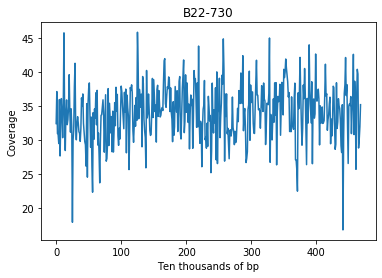

In [4]:
coverages = []
samfile = pysam.AlignmentFile("work/data/ion/B22-730.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("B22-730")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

Avg coverage 35.70759295934027
Genome covered 100.0%


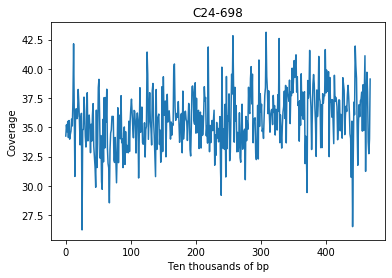

In [5]:
coverages = []
samfile = pysam.AlignmentFile("work/data/ion/C24-698.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("C24-698")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

### Средний процент ошибок в ридах

```
$ awk 'NR>2 && /NM/ {c++; split($12, a, ":"); s += a[3] / length($10)} END {print s/c*100. "%"}'\
B22-730.sam
0.743526%
```

```
$ awk 'NR>2 && /NM/ {c++; split($12, a, ":"); s += a[3] / length($10)} END {print s/c*100. "%"}'\
C24-698.sam
0.409784%
```

## Статистика инделов

```
$ samtools stats C24-698.sam | awk '/^ID/ {print $2, $3, $4}' > c24.indels
```

```
$ samtools stats B22-730.sam | awk '/^ID/ {print $2, $3, $4}' > b22.indels
```

Mean insert length = 1.0799336272936697
Mean del length = 1.0552690439531838
Mean indel length = 1.092348862259324


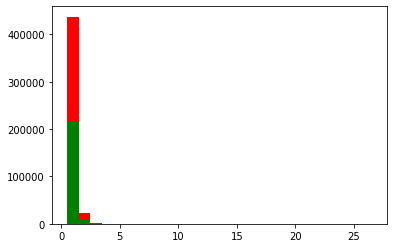

In [79]:
data = pd.read_csv("work/data/ion/c24.indels", sep=' ', header=None).values
p1 = plt.bar(data[:,0], data[:,2], 1, color='g')
p2 = plt.bar(data[:,0], data[:,1], 1, bottom=data[:,2], color='r')

print(f"Mean insert length = {np.sum(data[:,1]*data[:,0])/np.sum(data[:,1])}")
print(f"Mean del length = {np.sum(data[:,2]*data[:,0])/np.sum(data[:,2])}")
print(f"Mean indel length = {np.sum((data[:,0] + data[:,1])*data[:,0])/np.sum(data[:,0] + data[:,1])}")
plt.show()

Mean insert length = 1.0903606965174129
Mean del length = 1.0638842086594098
Mean indel length = 1.097838000227906


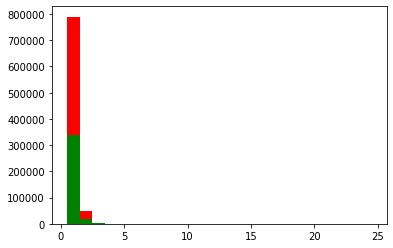

In [80]:
data = pd.read_csv("work/data/ion/b22.indels", sep=' ', header=None).values
p1 = plt.bar(data[:,0], data[:,2], 1, color='g')
p2 = plt.bar(data[:,0], data[:,1], 1, bottom=data[:,2], color='r')

print(f"Mean insert length = {np.sum(data[:,1]*data[:,0])/np.sum(data[:,1])}")
print(f"Mean del length = {np.sum(data[:,2]*data[:,0])/np.sum(data[:,2])}")
print(f"Mean indel length = {np.sum((data[:,0] + data[:,1])*data[:,0])/np.sum(data[:,0] + data[:,1])}")

plt.show()

## Статистика длин инделов в завимости от длины гомополимерного участка

497384it [05:06, 1624.03it/s]


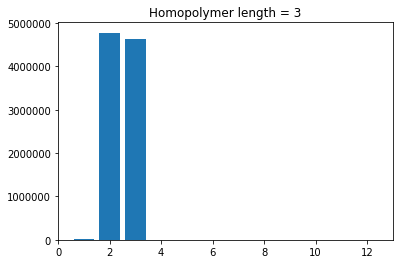

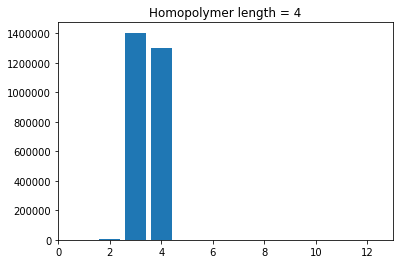

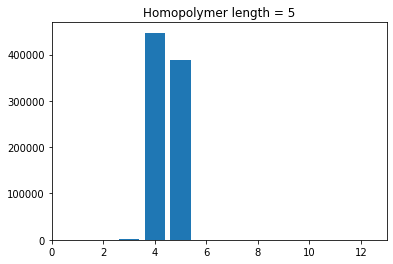

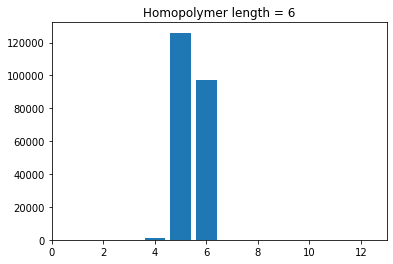

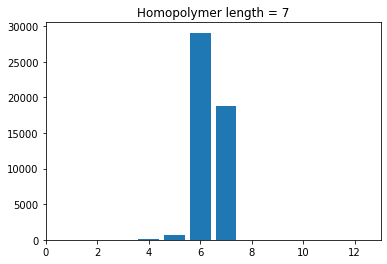

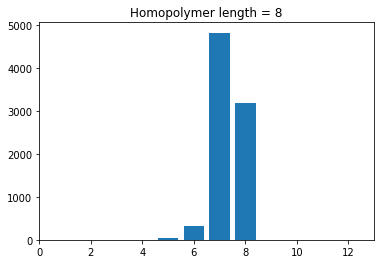

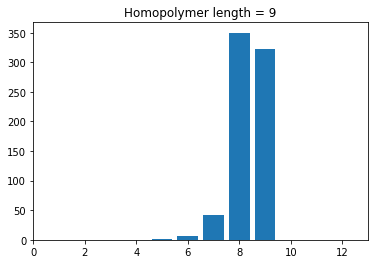

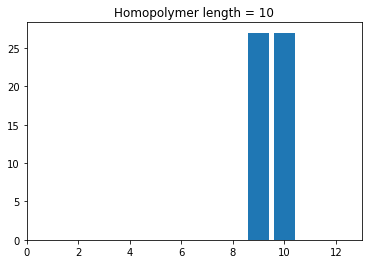

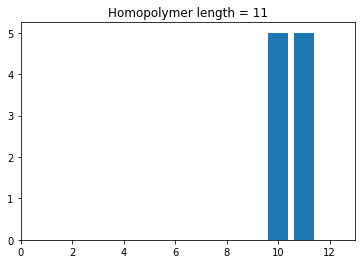

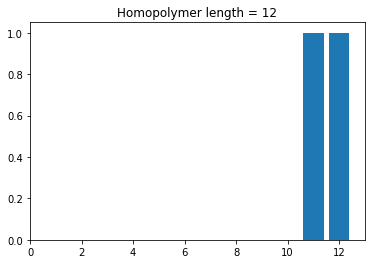

In [7]:
hp_indel = defaultdict(Counter)
    
with pysam.AlignmentFile('work/data/ion/B22-730.sorted', 'rb') as bamfile:
    #for k in range(3, 4):
    poly_window = deque(maxlen=20)
    read_window = deque(maxlen=20)

    for read in tqdm(bamfile):
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
            qry = read.query_sequence
        except:
            continue

        for read_p, ref_p, ref in aln_pairs:
            poly_window.append(ref)
            read_window.append(qry[read_p] if read_p is not None else None)

            if poly_window.count(poly_window[0]) == len(poly_window)-1:
                #while 3 > len(poly_window)
                while True:
                    poly_window.popleft()
                    read_window.popleft()
                                            
                    if len(poly_window) == 0:
                        break
                        
                    if poly_window.count(poly_window[0]) == len(poly_window)-1:
                        hp_indel[len(poly_window)][read_window.count(poly_window[0])] += 1
                continue

            else:
                hp_indel[len(poly_window)][read_window.count(poly_window[0])] += 1
                #hp_indel[k][read_window.count(poly_window[0])] += 1

for k in range(3, 21):
    try: 
        x, y = zip(*sorted(hp_indel[k].items()))
        if list(x) == [0]:
            continue
        plt.bar(x[1:], y[1:])
        plt.title(f'Homopolymer length = {k}')
        plt.xlim(0,13)
        plt.show()
    except ValueError:
        pass

686667it [06:33, 1743.10it/s]


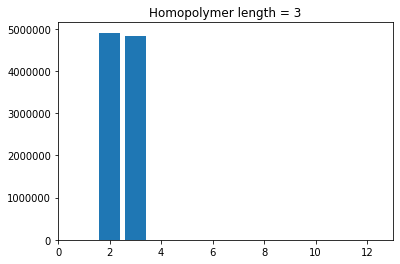

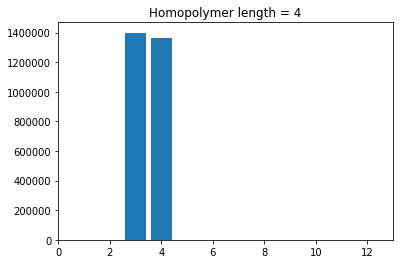

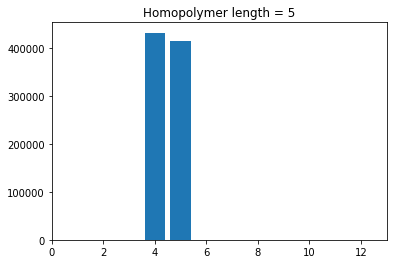

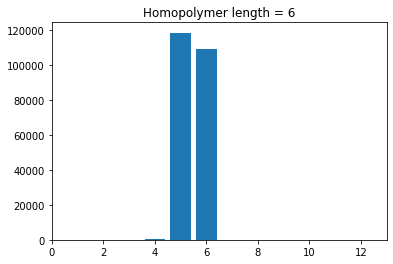

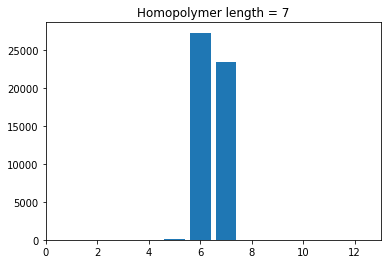

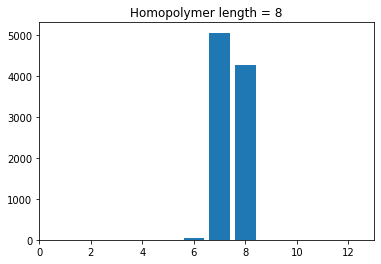

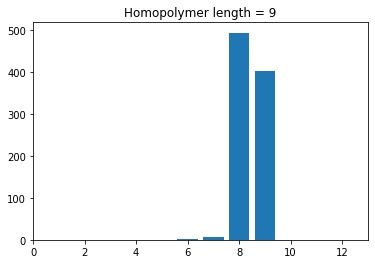

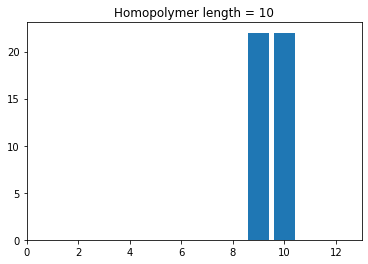

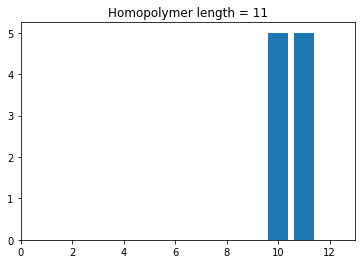

In [18]:
hp_indel = defaultdict(Counter)
    
with pysam.AlignmentFile('work/data/ion/C24-698.sorted', 'rb') as file:
    #for k in range(3, 4):
    poly_window = deque(maxlen=20)
    read_window = deque(maxlen=20)

    for read in tqdm(file):
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
            qry = read.query_sequence
        except:
            continue

        for read_p, ref_p, ref in aln_pairs:
            poly_window.append(ref)
            read_window.append(qry[read_p].upper() if read_p is not None else None)

            if (poly_window.count(poly_window[0]) == len(poly_window)-1) or (ref is None):
                #while 3 > len(poly_window)
                while True:
                    poly_window.popleft()
                    read_window.popleft()
                                            
                    if len(poly_window) == 0:
                        break
                        
                    hp_indel[len(poly_window)][read_window.count(poly_window[0].upper() if poly_window[0] is not None else None )] += 1

            else:
                hp_indel[len(poly_window)][read_window.count(poly_window[0].upper() if poly_window[0] is not None else None )] += 1
                #hp_indel[k][read_window.count(poly_window[0])] += 1

for k in range(3, 21):
    try: 
        x, y = zip(*sorted(hp_indel[k].items()))
        if list(x) == [0]:
            continue
        plt.bar(x[1:], y[1:])
        plt.title(f'Homopolymer length = {k}')
        plt.xlim(0,13)
        plt.show()
    except ValueError:
        pass

## Статистика качества нуклеотидов

497384it [01:35, 5228.25it/s]



Avg insertion qty: 18.484183321897063
Mean mismatch qty: 19.14349070550121



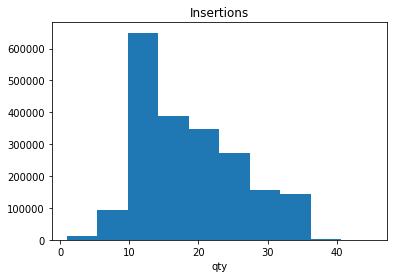

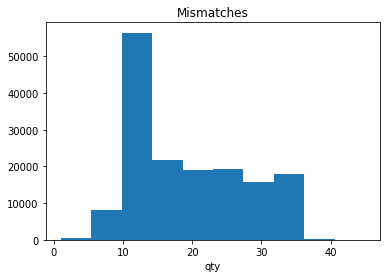

In [15]:
ins_qty = []
mism_qty = []

with pysam.AlignmentFile('work/data/ion/B22-730.sorted', 'rb') as file:
    for read in tqdm(file):
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
        except ValueError:
            continue
            
        qty = read.query_qualities
        seq = read.query_sequence
        
        for read_p, ref_p, ref in aln_pairs:   
            if ref_p is None: # erroneous insertion
                ins_qty.append(qty[read_p])
            elif (read_p is not None) and (seq[read_p].lower() != ref.lower()): # mismatch
                mism_qty.append(qty[read_p])
            else:
                pass

print(f"""
Avg insertion qty: {np.mean(ins_qty)}
Mean mismatch qty: {np.mean(mism_qty)}
""")

plt.hist(ins_qty)
plt.xlabel('qty')
plt.title('Insertions')
plt.show()

plt.hist(mism_qty)
plt.xlabel('qty')
plt.title('Mismatches')
plt.show()

686667it [01:24, 8082.93it/s]



Avg insertion qty: 17.92578946974292
Mean mismatch qty: 21.042596382635317



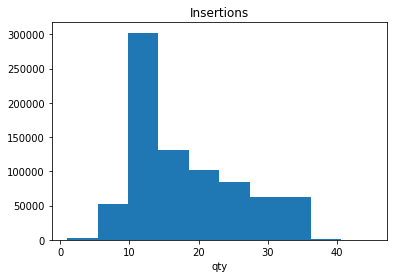

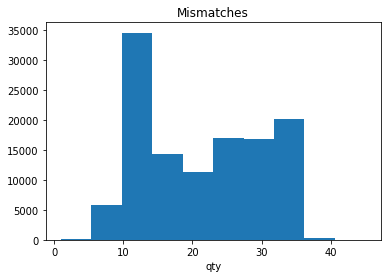

In [2]:
ins_qty = []
mism_qty = []

with pysam.AlignmentFile('work/data/ion/C24-698.sorted', 'rb') as file:
    for read in tqdm(file):
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
        except ValueError:
            continue
            
        qty = read.query_qualities
        seq = read.query_sequence
        
        for read_p, ref_p, ref in aln_pairs:   
            if ref_p is None: # erroneous insertion
                ins_qty.append(qty[read_p])
            elif (read_p is not None) and (seq[read_p].lower() != ref.lower()): # mismatch
                mism_qty.append(qty[read_p])
            else:
                pass

print(f"""
Avg insertion qty: {np.mean(ins_qty)}
Mean mismatch qty: {np.mean(mism_qty)}
""")

plt.hist(ins_qty)
plt.xlabel('qty')
plt.title('Insertions')
plt.show()

plt.hist(mism_qty)
plt.xlabel('qty')
plt.title('Mismatches')
plt.show()

### Таблица

In [81]:
mat = Counter()

with pysam.AlignmentFile('work/data/ion/B22-730.sorted', 'rb') as file:
    for read in tqdm(file):
        try:
            aligned_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue

        for p in aligned_pairs:
            if p[0] is None and not (p[2] is None or p[2].upper() == 'N'):
                mat[(p[2].upper(), '-')] += 1
            elif p[0] is not None and (p[2] is None or p[2].upper() == 'N'):
                mat[('-', read.seq[p[0]].upper())] += 1
            elif read.seq[p[0]].upper() != p[2].upper():
                mat[(p[2].upper(), read.seq[p[0]].upper())] += 1
            else:
                pass

for n, i in enumerate('ACTG-'):
    print(f" {i:>{8}}", end="")
print()
for i in 'ACTG-':
    print(f"{i}", end=" ")
    for j in 'ACTG-': 
        print(f"{mat[(i,j)]:>8}", end=" ")
    print()

497384it [03:52, 2138.31it/s]

        A        C        T        G        -
A        0     9147    11173    23657   119254 
C    10360        0    16671     8092    72479 
T    11325    24493        0     9060   119372 
G    17215     7209    10563        0    72804 
-   590244   442044   591824   440955        0 


In [67]:
mat = Counter()

with pysam.AlignmentFile('work/data/ion/C24-698.sorted', 'rb') as file:
    for read in tqdm(file):
        try:
            aligned_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue

        for p in aligned_pairs:
            if p[0] is None and not (p[2] is None or p[2].upper() == 'N'):
                mat[(p[2].upper(), '-')] += 1
            elif p[0] is not None and (p[2] is None or p[2].upper() == 'N'):
                mat[('-', read.seq[p[0]].upper())] += 1
            elif read.seq[p[0]].upper() != p[2].upper():
                mat[(p[2].upper(), read.seq[p[0]].upper())] += 1
            else:
                pass

for n, i in enumerate('ACTG-'):
    print(f" {i:>{8}}", end="")
print()
for i in 'ACTG-':
    print(f"{i}", end=" ")
    for j in 'ACTG-': 
        print(f"{mat[(i,j)]:>8}", end=" ")
    print()

686667it [02:23, 4770.47it/s]

        A        C        T        G        -
A        0     5124     6488    21938    37199 
C     6751        0    13966     5380    82132 
T     6549    22450        0     5248    37728 
G    14257     4978     7069        0    82142 
-   220153   180769   220640   179672        0 


## 2. Повторить любые два пункта из задания 1 с помощью другого выравнивателя, сравнить результаты


Используем tmap-ion

```
$ zcat B22-730.fastq.gz | conda run tmap-ion map1 -f DH10B-K12.fasta -i fastq -s B22-730.ion.sam
$ zcat C24-698.fastq.gz  | conda run tmap-ion map1 -f DH10B-K12.fasta -i fastq -s C24-698.ion.sam
$ conda run samtools sort -o C24-698.ion.sorted C24-698.ion.sam
$ conda run samtools sort -o B22-730.ion.sorted B22-730.ion.sam
$ conda run samtools index C24-698.ion.sorted
$ conda run samtools index B22-730.ion.sorted

```

Avg coverage 29.746353481077787
Genome covered 99.97957806184496%


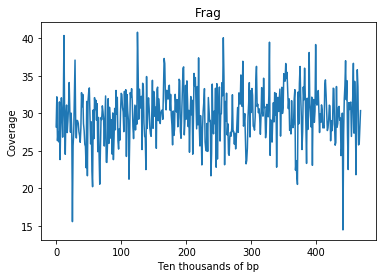

In [85]:
coverages = []
samfile = pysam.AlignmentFile("work/data/ion/B22-730.ion.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("Frag")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

Avg coverage 34.19363382510976
Genome covered 99.99965856738717%


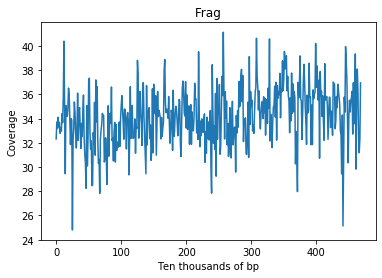

In [86]:
coverages = []
samfile = pysam.AlignmentFile("work/data/ion/C24-698.ion.sorted", "rb")
samfilelength = samfile.lengths[0]
nonzerobp = 0
tlen = []
for pileupcolumn in grouper(samfile.pileup(), 10000):
    bucket = [x.nsegments for x in pileupcolumn if x != None]
    nonzerobp += np.count_nonzero(bucket)
    avg_coverage = np.mean(bucket)
    coverages.append(avg_coverage)
samfile.close()

plt.plot(list(range(0, len(coverages))), coverages)
plt.title("Frag")
plt.ylabel("Coverage")
plt.xlabel("Ten thousands of bp")
print(f"Avg coverage {np.mean(coverages)}")
print(f"Genome covered {nonzerobp / samfilelength * 100}%")

## Средний процент ошибок в ридах

```
$ awk 'NR>2 && /NM/ {c++; split($12, a, ":"); s += a[3] / length($10)} END {print s/c*100. "%"}'\
B22-730.ion.sam
0%
```

```
$ awk 'NR>2 && /NM/ {c++; split($12, a, ":"); s += a[3] / length($10)} END {print s/c*100. "%"}'\
C24-698.ion.sam
0%
```